In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data directory
import os
os.chdir('/content/drive/MyDrive/Saarland')

Mounted at /content/drive


In [3]:
# Load data - only columns we need
cols = ['Season', 'Week', 'GameStatus', 'AwayTeam', 'AwayScore', 'HomeTeam', 'HomeScore', 'PostSeason']
nfl = pd.read_csv('nfl_scores.csv', usecols=cols)

nfl.head()

,Season,Week,GameStatus,AwayTeam,AwayScore,HomeTeam,HomeScore,PostSeason
0,2017,Hall Of Fame,FINAL,Cardinals,18.0,Cowboys,20.0,0
1,2017,Preseason Week 1,FINAL,Texans,17.0,Panthers,27.0,0
2,2017,Preseason Week 1,FINAL,Vikings,17.0,Bills,10.0,0
3,2017,Preseason Week 1,FINAL,Falcons,20.0,Dolphins,23.0,0
4,2017,Preseason Week 1,FINAL,Redskins,3.0,Ravens,23.0,0


In [4]:

# Filter to completed games only
nfl = nfl[nfl['GameStatus'] == 'FINAL'].copy()

# Drop rows with missing scores
nfl = nfl.dropna(subset=['HomeScore', 'AwayScore'])
nfl['HomeScore'] = nfl['HomeScore'].astype(int)
nfl['AwayScore'] = nfl['AwayScore'].astype(int)

# Rename for consistency
nfl = nfl.rename(columns={'AwayTeam': 'AwayTeam', 'HomeTeam': 'HomeTeam'})

# Tag regular season vs playoffs (PostSeason=1 means playoffs)
nfl['is_regular'] = nfl['PostSeason'] == 0

# Remove preseason games (contains 'Preseason' in Week)
nfl = nfl[~nfl['Week'].str.contains('Preseason', na=False)]
nfl = nfl[~nfl['Week'].str.contains('Hall Of Fame', na=False)]

print(f"Total games: {len(nfl)}")
print(f"Regular season: {nfl['is_regular'].sum()}")
print(f"Playoffs: {(~nfl['is_regular']).sum()}")
print(f"Seasons: {nfl['Season'].min()}-{nfl['Season'].max()}")

Total games: 2377
Regular season: 2279
Playoffs: 98
Seasons: 2017-2025


## Calculate Per-Team Win Percentage (Peko's Method)

Following Getty et al. (2018), we calculate win percentage for each team, then use random splits to compute R*.

In [5]:
def get_team_games(df, team):
    """Get all games for a specific team"""
    home_games = df[df['HomeTeam'] == team].copy()
    home_games['is_home'] = True
    home_games['team_score'] = home_games['HomeScore']
    home_games['opp_score'] = home_games['AwayScore']
    home_games['opponent'] = home_games['AwayTeam']

    away_games = df[df['AwayTeam'] == team].copy()
    away_games['is_home'] = False
    away_games['team_score'] = away_games['AwayScore']
    away_games['opp_score'] = away_games['HomeScore']
    away_games['opponent'] = away_games['HomeTeam']

    team_games = pd.concat([home_games, away_games])
    # NFL doesn't have dates in this dataset, use Week as proxy
    team_games = team_games.sort_values('Week')

    # Calculate wins (1 for win, 0.5 for tie, 0 for loss)
    team_games['win'] = 0.0
    team_games.loc[team_games['team_score'] > team_games['opp_score'], 'win'] = 1.0
    team_games.loc[team_games['team_score'] == team_games['opp_score'], 'win'] = 0.5

    return team_games

def calculate_r_peko_method(df, n_folds=100):
    """
    Calculate R* using Peko's method:
    1. For each team, randomly split games K times
    2. Calculate win percentage for each split
    3. Pool all (x,y) pairs across teams and splits
    4. Transform to S,T coordinates
    5. Calculate R = 1 - var(T)/var(S)
    """
    teams = sorted(set(df['HomeTeam']).union(set(df['AwayTeam'])))

    # Collect all (x,y) pairs
    XY_pairs = []

    for team in teams:
        team_games = get_team_games(df, team)
        n_games = len(team_games)

        # Skip teams with too few games
        if n_games < 4:
            continue

        # Perform K random splits for this team
        for k in range(n_folds):
            # Randomly assign games to fold A or B
            fold = np.random.randint(0, 2, n_games)

            games_a = team_games.iloc[fold == 0]
            games_b = team_games.iloc[fold == 1]

            # Calculate win percentage
            if len(games_a) > 0 and len(games_b) > 0:
                x = games_a['win'].sum() / len(games_a)
                y = games_b['win'].sum() / len(games_b)
                XY_pairs.append((x, y))

    if len(XY_pairs) < 3:
        return np.nan

    # Convert to arrays
    X = np.array([x for x, y in XY_pairs])
    Y = np.array([y for x, y in XY_pairs])

    # Transform to S, T coordinates
    S = (X + Y) / np.sqrt(2)
    T = (Y - X) / np.sqrt(2)

    # Calculate variances (using ddof=0)
    var_S = np.var(S, ddof=0)
    var_T = np.var(T, ddof=0)

    # Calculate R
    if var_S > 1e-12:
        R = 1 - var_T / var_S
    else:
        R = np.nan

    return R

## Calculate R by Season

In [6]:
results = []

for season in sorted(nfl['Season'].unique()):
    season_data = nfl[nfl['Season'] == season]

    # Regular season only
    reg_only = season_data[season_data['is_regular']]

    # All games (regular + playoffs)
    all_games = season_data

    n_teams = len(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

    if len(reg_only) >= 20:
        r_reg = calculate_r_peko_method(reg_only, n_folds=100)
        r_all = calculate_r_peko_method(all_games, n_folds=100)

        results.append({
            'Season': season,
            'N_Teams': n_teams,
            'Games_Regular': len(reg_only),
            'Games_All': len(all_games),
            'R_Regular': r_reg,
            'R_All': r_all
        })

results_df = pd.DataFrame(results)
results_df = results_df.round({'R_Regular': 2, 'R_All': 2})
results_df

,Season,N_Teams,Games_Regular,Games_All,R_Regular,R_All
0,2017,34,257,268,0.62,0.60
1,2018,34,257,268,0.52,0.48
2,2019,34,257,268,0.61,0.59
3,2020,32,256,269,0.70,0.66
4,2021,34,273,286,0.47,0.46
5,2022,32,271,284,0.57,0.55
6,2023,32,272,285,0.44,0.40
7,2024,32,272,285,0.72,0.69
8,2025,32,164,164,0.51,0.50


## Visualize Results

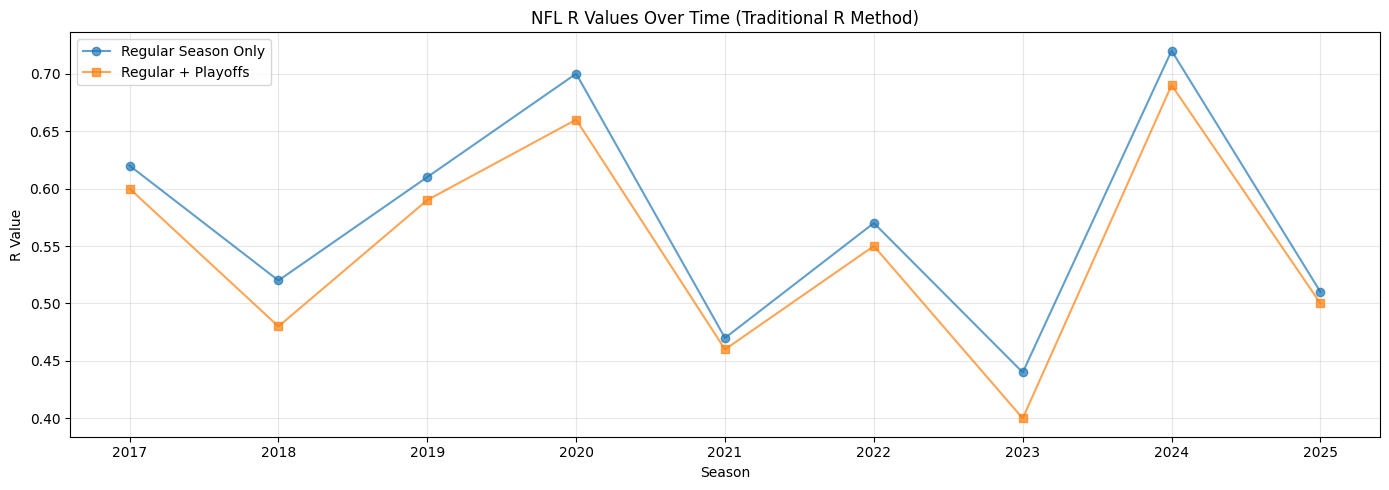

In [7]:
fig, (ax1) = plt.subplots(1, figsize=(14, 5))

# R values over time
ax1.plot(results_df['Season'], results_df['R_Regular'], 'o-', label='Regular Season Only', alpha=0.7)
ax1.plot(results_df['Season'], results_df['R_All'], 's-', label='Regular + Playoffs', alpha=0.7)
#ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='R = 0.5')
ax1.set_xlabel('Season')
ax1.set_ylabel('R Value')
ax1.set_title('NFL R Values Over Time (Traditional R Method)')
ax1.legend()
ax1.grid(alpha=0.3)


plt.tight_layout()
plt.show()

In [8]:
# Summary statistics
print("\nOverall Summary:")
print(f"Mean R (Regular): {results_df['R_Regular'].mean():.3f}")
print(f"Mean R (All): {results_df['R_All'].mean():.3f}")
print(f"Std R (Regular): {results_df['R_Regular'].std():.3f}")
print(f"Std R (All): {results_df['R_All'].std():.3f}")


Overall Summary:
Mean R (Regular): 0.573
Mean R (All): 0.548
Std R (Regular): 0.098
Std R (All): 0.096


## P vs Q Scatter Plot

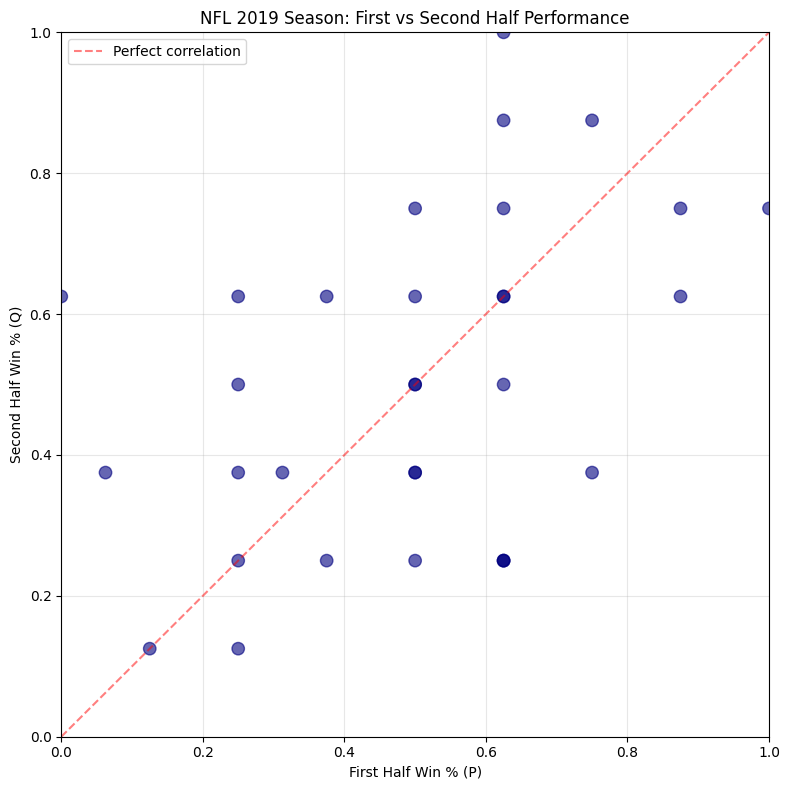


Correlation between first and second half: 0.433


In [9]:
# Analyze a recent season for visualization
example_season = 2019
season_data = nfl[(nfl['Season'] == example_season) & (nfl['is_regular'])]
teams = sorted(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

P_values = []
Q_values = []
game_counts = []

for team in teams:
    team_games = get_team_games(season_data, team)
    n_games = len(team_games)

    if n_games < 4:
        continue

    # Split into first and second half
    half = n_games // 2
    first_half = team_games.iloc[:half]
    second_half = team_games.iloc[half:]

    p = first_half['win'].sum() / len(first_half)
    q = second_half['win'].sum() / len(second_half)

    P_values.append(p)
    Q_values.append(q)
    game_counts.append(n_games)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [g * 5 for g in game_counts]
ax.scatter(P_values, Q_values, s=sizes, alpha=0.6, color='navy')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect correlation')
ax.set_xlabel('First Half Win % (P)')
ax.set_ylabel('Second Half Win % (Q)')
ax.set_title(f'NFL {example_season} Season: First vs Second Half Performance')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between first and second half: {np.corrcoef(P_values, Q_values)[0,1]:.3f}")